In [1]:
import os
import random
import numpy as np
import torch


def set_seed(seed: int):
    """Set random seed for reproducibility."""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Load data

In [2]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from dataset import get_experiment_data

trainloaders, valloaders, testloaders, csv_paths, min_vals, max_vals = (
    get_experiment_data(
        data_root="C:/Users/maher/SimpleFL/data/processed",
        num_clients=20,
        input_size=24 * 6,
        forecast_horizon=24,
        stride=24,
        batch_size=32,
        valid_set_size=0.15,
        test_set_size=0.15,
    )
)
seq_len = 24 * 6 + 24

### Client subroutine

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset


def get_client_p_matrix(cid: int) -> DataLoader:
    trainloader = trainloaders[cid]
    p_list = []
    for x, y in trainloader:
        z = torch.cat((x, y), dim=1)
        p_list.extend(z)
    Pdataset = TensorDataset(torch.stack(p_list))
    Ploader = DataLoader(
        Pdataset, batch_size=1
    )  # batch_size is hardcoded to 1, must not be changed
    return Ploader

In [4]:
from typing import List, Tuple


def client_subroutine(
    Ploader: DataLoader, cluster_centroids: List[torch.tensor], n_clusters: int
) -> Tuple[torch.tensor, torch.tensor]:
    closest_centroid_id_list = []
    closest_centroid_distances = []
    closest_centroid_euclidean_dist = []

    for p_d in Ploader:
        distances = []
        for k in range(n_clusters):
            centroid_k = cluster_centroids[k]
            dist = torch.norm(p_d[0] - centroid_k)
            distances.append(dist)
        min_dist, min_idx = torch.min(torch.tensor(distances), dim=0)
        closest_centoid = cluster_centroids[min_idx]
        diff = p_d[0].squeeze(0) - closest_centoid

        closest_centroid_id_list.append(min_idx)
        closest_centroid_distances.append(diff)
        closest_centroid_euclidean_dist.append(min_dist)

    j_list = [torch.zeros(seq_len, 1) for _ in range(n_clusters)]
    v_list = [0 for _ in range(n_clusters)]
    for centoid_id, centroid_distance in zip(
        closest_centroid_id_list, closest_centroid_distances
    ):
        j_list[centoid_id] += centroid_distance
        v_list[centoid_id] += 1
    return torch.stack(j_list, dim=0), torch.tensor(v_list)

### Finding cluster centroids

In [5]:
from tqdm import tqdm


def find_centroids(
    n_clusters: int, n_iter: int, alpha: float, n_clients: int, seed: int = 19
) -> List[torch.tensor]:
    # randomly initialize cluster centroids
    set_seed(seed)
    cluster_centroids = []
    for k in range(n_clusters):
        cluster_centroids.append(torch.rand(seq_len, 1))

    # distributed k-means
    for _ in tqdm(range(n_iter)):
        # perform client subroutine
        j_clients = []
        v_clients = []
        for cid in range(n_clients):  # sample size is defined by outer logic TODO
            Ploader = get_client_p_matrix(cid)
            j, v = client_subroutine(Ploader, cluster_centroids, n_clusters)
            j_clients.append(j)
            v_clients.append(v)
        # aggregate client results
        j_sum = torch.sum(torch.stack(j_clients), dim=0)
        v_sum = torch.sum(torch.stack(v_clients), dim=0)
        # update cluster centroids
        for k in range(n_clusters):
            cluster_centroids[k] += alpha * (j_sum[k] / v_sum[k] if v_sum[k] else 0)
    return cluster_centroids


n_clusters = 3
n_iter = 10
alpha = 1e-0
n_clients = 20
seed = 88

cluster_centroids = find_centroids(n_clusters, n_iter, alpha, n_clients, seed)

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


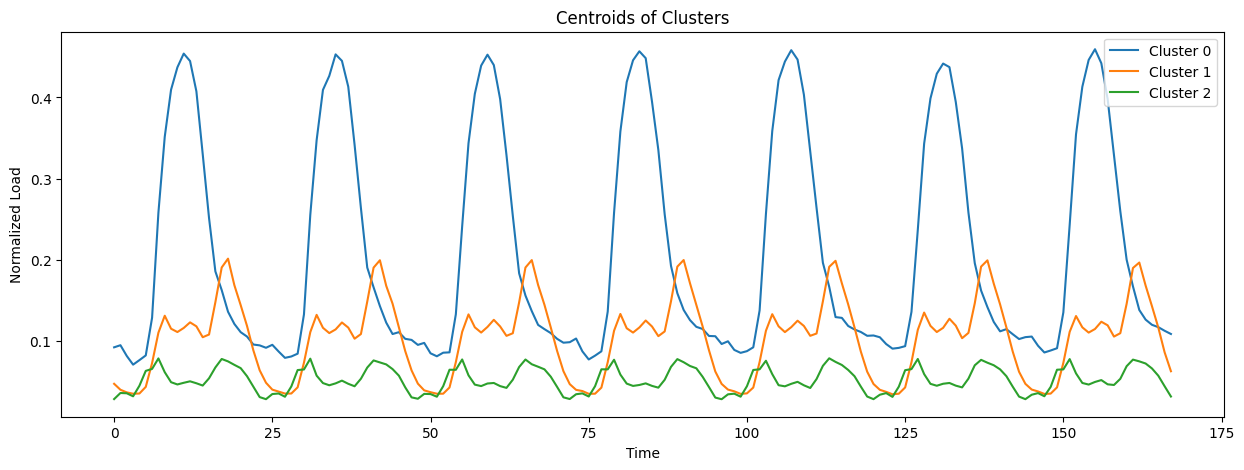

In [6]:
import matplotlib.pyplot as plt


def plot_cluster_centroids(cluster_centroids, n_clusters):
    plt.figure(figsize=(15, 5))
    for k in range(n_clusters):
        plt.plot(cluster_centroids[k].detach().numpy(), label=f"Cluster {k}")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Normalized Load")
    plt.title("Centroids of Clusters")
    plt.show()


plot_cluster_centroids(cluster_centroids, n_clusters)

### Assign client to cluster

In [7]:
def filter_outliers(
    Ploader: DataLoader,
    cluster_centroids: List[torch.tensor],
    distance_percentile: float,
) -> DataLoader:
    distances = []
    for p_d in Ploader:
        sample_distances = []
        for k in range(n_clusters):
            centroid_k = cluster_centroids[k]
            dist = torch.norm(p_d[0] - centroid_k)
            sample_distances.append(dist)
        min_dist, min_idx = torch.min(torch.tensor(sample_distances), dim=0)
        distances.append(min_dist)

    threshold = torch.quantile(torch.tensor(distances), distance_percentile)
    filtered_data = []
    for p_d, dist in zip(Ploader, distances):
        if dist < threshold:
            filtered_data.append(p_d[0].squeeze(0))

    filtered_dataset = TensorDataset(torch.stack(filtered_data))
    filtered_loader = DataLoader(filtered_dataset, batch_size=1)
    return filtered_loader


def compute_avg_load(Ploader: DataLoader) -> torch.tensor:
    n_samples = 0
    total_load = torch.zeros(seq_len, 1)
    for p_d in Ploader:
        total_load += p_d[0].squeeze(0)
        n_samples += 1
    return total_load / n_samples


def assign_cluster(cid: int, cluster_centroids: List[torch.tensor]) -> int:
    Ploader = get_client_p_matrix(cid)
    filtered_Ploader = filter_outliers(Ploader, cluster_centroids, 0.95)
    avg_load = compute_avg_load(filtered_Ploader)

    distances = []
    for k in range(n_clusters):
        centroid_k = cluster_centroids[k]
        dist = torch.norm(avg_load - centroid_k)
        distances.append(dist)
    min_dist, min_idx = torch.min(torch.tensor(distances), dim=0)
    return min_idx

Client 0 is assigned to cluster 2
Client 1 is assigned to cluster 1
Client 2 is assigned to cluster 2
Client 3 is assigned to cluster 1
Client 4 is assigned to cluster 2
Client 5 is assigned to cluster 1
Client 6 is assigned to cluster 1
Client 7 is assigned to cluster 2
Client 8 is assigned to cluster 1
Client 9 is assigned to cluster 1
Client 10 is assigned to cluster 0
Client 11 is assigned to cluster 2
Client 12 is assigned to cluster 1
Client 13 is assigned to cluster 2
Client 14 is assigned to cluster 2
Client 15 is assigned to cluster 2
Client 16 is assigned to cluster 1
Client 17 is assigned to cluster 1
Client 18 is assigned to cluster 1
Client 19 is assigned to cluster 1


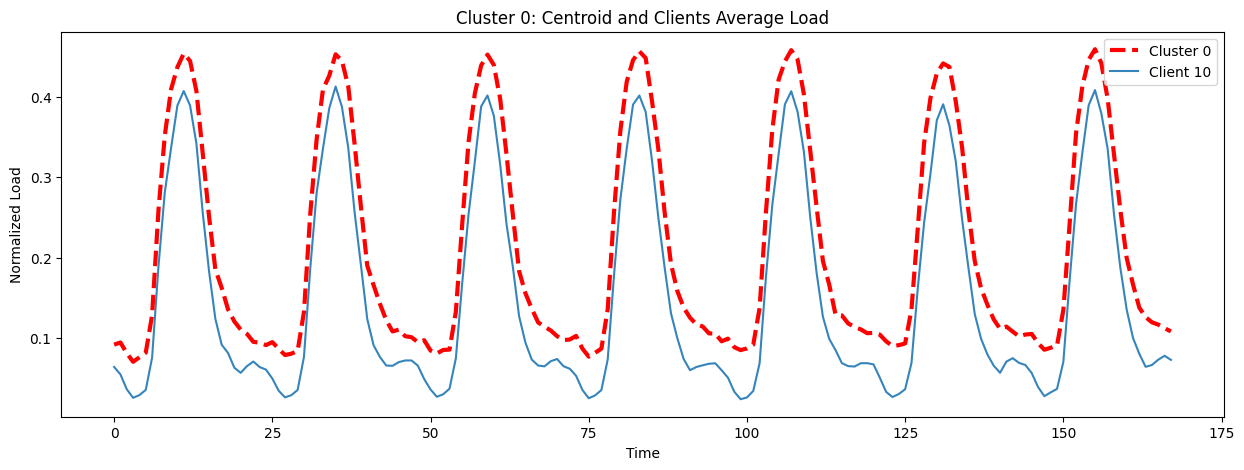

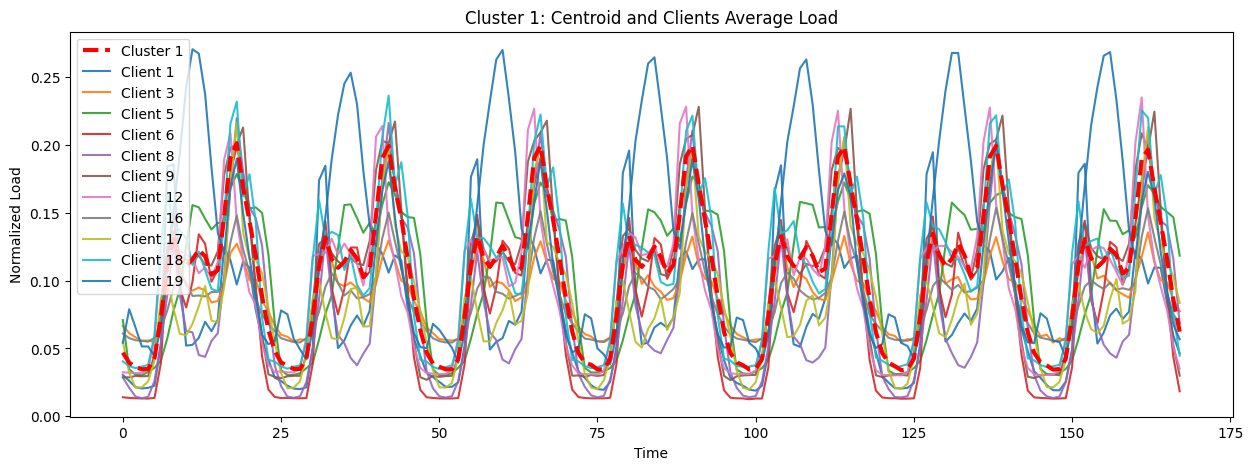

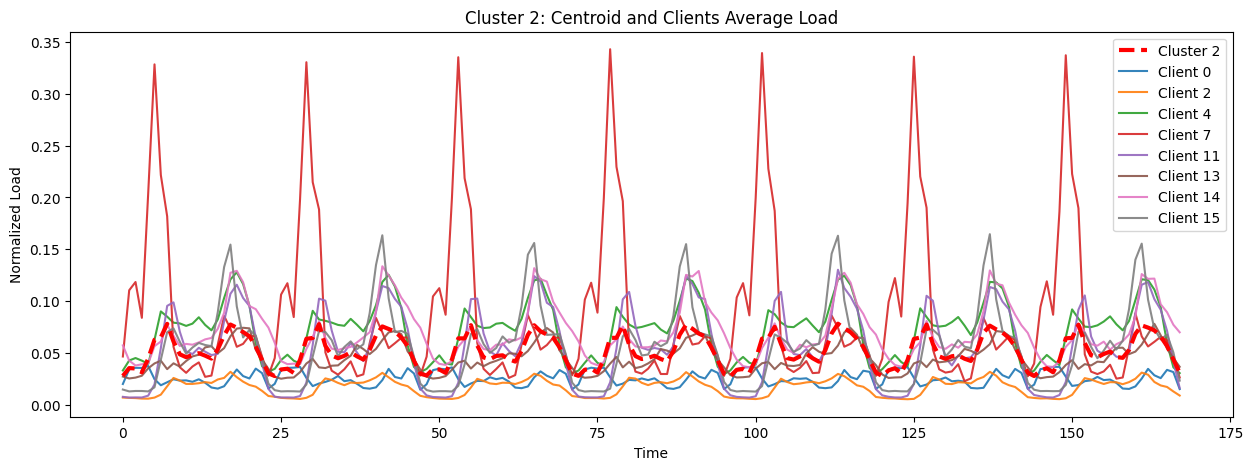

In [8]:
# assign clients to clusters
cluster_clients = {k: [] for k in range(n_clusters)}
for cid in range(20):
    cluster = assign_cluster(cid, cluster_centroids)
    cluster_clients[cluster.item()].append(cid)
    print(f"Client {cid} is assigned to cluster {cluster}")

# visualize cluster centroids and clients
for cluster in cluster_clients.keys():
    cluster_centroid = cluster_centroids[cluster]
    plt.figure(figsize=(15, 5))
    plt.plot(
        cluster_centroid,
        label=f"Cluster {cluster}",
        linestyle="--",
        color="red",
        linewidth=3,
        zorder=3,
    )
    for cid in cluster_clients[cluster]:
        Ploader = get_client_p_matrix(cid)
        filtered_Ploader = filter_outliers(Ploader, cluster_centroids, 0.95)
        avg_load = compute_avg_load(filtered_Ploader)
        plt.plot(avg_load, label=f"Client {cid}", alpha=0.9)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Normalized Load")
    plt.title(f"Cluster {cluster}: Centroid and Clients Average Load")
    plt.show()